# World Cup Analytics - Requêtes SQL Avancées

**Auteur** : Short Kings Team  
**Date** : 17/12/2024

## Objectifs
Ce notebook démontre une **maîtrise avancée de SQL** à travers:
- Démonstration de l'intérêt du **partitionnement** avec `EXPLAIN ANALYZE`
- Utilisation de **vues** pré-calculées
- **Window Functions** (RANK, SUM OVER, AVG mobile)
- **CTEs** (Common Table Expressions)
- **Requêtes paramétrées** pour l'analyse flexible
- **Conditional Aggregation** et techniques avancées

# 1. Setup et Connexion

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

# Charger les variables d'environnement
load_dotenv()

# Connexion à la base de données
DATABASE_URL = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(DATABASE_URL)

# Configuration des visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("Connexion établie avec succès!")

Connexion établie avec succès!


In [2]:
# Fonctions utilitaires
def run_query(query: str, params: dict = None) -> pd.DataFrame:
    """Exécute une requête SQL et retourne un DataFrame."""
    with engine.connect() as conn:
        return pd.read_sql(text(query), conn, params=params)

def run_explain(query: str) -> pd.DataFrame:
    """Exécute EXPLAIN ANALYZE et retourne le plan d'exécution."""
    explain_query = f"EXPLAIN (ANALYZE, BUFFERS, FORMAT TEXT) {query}"
    with engine.connect() as conn:
        result = conn.execute(text(explain_query))
        return pd.DataFrame(result.fetchall(), columns=['Plan'])

def display_plan(df_plan):
    """Affiche le plan d'exécution de manière lisible."""
    for _, row in df_plan.iterrows():
        print(row['Plan'])

# Liste des équipes disponibles (pour les paramètres)
df_teams = run_query("SELECT nom_standard FROM teams ORDER BY nom_standard")
TEAMS_LIST = df_teams['nom_standard'].tolist()
print(f"{len(TEAMS_LIST)} équipes disponibles")

226 équipes disponibles


# 2. Démonstration du Partitionnement

La table `matches` est partitionnée par `edition`. Voyons l'impact sur les performances.

In [3]:
# Exemple 1: Partition Pruning
# Requête SANS filtre sur edition (scan toutes les partitions)
print("=" * 80)
print("SANS filtre edition - Scan de TOUTES les partitions")
print("=" * 80)

query_all = "SELECT COUNT(*) FROM matches WHERE home_team_id = 1"
plan_all = run_explain(query_all)
display_plan(plan_all)

SANS filtre edition - Scan de TOUTES les partitions
Aggregate  (cost=57.45..57.46 rows=1 width=8) (actual time=0.588..0.592 rows=1.00 loops=1)
  Buffers: shared hit=29
  ->  Append  (cost=0.14..57.38 rows=28 width=0) (actual time=0.384..0.587 rows=3.00 loops=1)
        Buffers: shared hit=29
        ->  Index Only Scan using matches_1930_home_team_id_edition_idx on matches_1930 matches_1  (cost=0.14..2.36 rows=1 width=0) (actual time=0.012..0.012 rows=0.00 loops=1)
              Index Cond: (home_team_id = 1)
              Heap Fetches: 0
              Index Searches: 1
              Buffers: shared hit=1
        ->  Index Only Scan using matches_1934_home_team_id_edition_idx on matches_1934 matches_2  (cost=0.14..2.36 rows=1 width=0) (actual time=0.015..0.015 rows=0.00 loops=1)
              Index Cond: (home_team_id = 1)
              Heap Fetches: 0
              Index Searches: 1
              Buffers: shared hit=1
        ->  Index Only Scan using matches_1938_home_team_id_edition

In [4]:
# Requête AVEC filtre sur edition (scan UNE partition)
print("=" * 80)
print("AVEC filtre edition = 2018 - Partition Pruning actif")
print("=" * 80)

query_filtered = "SELECT COUNT(*) FROM matches WHERE home_team_id = 1 AND edition = 2018"
plan_filtered = run_explain(query_filtered)
display_plan(plan_filtered)

print("\n" + "=" * 80)
print("CONCLUSION: Avec le filtre 'edition', PostgreSQL ne scanne qu'une partition")
print("=" * 80)

AVEC filtre edition = 2018 - Partition Pruning actif
Aggregate  (cost=1.96..1.97 rows=1 width=8) (actual time=0.021..0.022 rows=1.00 loops=1)
  Buffers: shared hit=1
  ->  Seq Scan on matches_2018 matches  (cost=0.00..1.96 rows=1 width=0) (actual time=0.018..0.019 rows=0.00 loops=1)
        Filter: ((home_team_id = 1) AND (edition = 2018))
        Rows Removed by Filter: 64
        Buffers: shared hit=1
Planning:
  Buffers: shared hit=10
Planning Time: 0.258 ms
Execution Time: 0.044 ms

CONCLUSION: Avec le filtre 'edition', PostgreSQL ne scanne qu'une partition


In [5]:
# Exemple 2: Requête sur une plage d'éditions
print("=" * 80)
print("Filtre edition BETWEEN 2014 AND 2022 - Scan de 3 partitions")
print("=" * 80)

query_range = "SELECT * FROM matches WHERE edition BETWEEN 2014 AND 2022"
plan_range = run_explain(query_range)
display_plan(plan_range)

Filtre edition BETWEEN 2014 AND 2022 - Scan de 3 partitions
Append  (cost=0.00..33.24 rows=1012 width=252) (actual time=0.013..0.255 rows=1012.00 loops=1)
  Buffers: shared hit=13
  ->  Seq Scan on matches_2014 matches_1  (cost=0.00..24.26 rows=884 width=277) (actual time=0.012..0.154 rows=884.00 loops=1)
        Filter: ((edition >= 2014) AND (edition <= 2022))
        Buffers: shared hit=11
  ->  Seq Scan on matches_2018 matches_2  (cost=0.00..1.96 rows=64 width=79) (actual time=0.007..0.016 rows=64.00 loops=1)
        Filter: ((edition >= 2014) AND (edition <= 2022))
        Buffers: shared hit=1
  ->  Seq Scan on matches_2022 matches_3  (cost=0.00..1.96 rows=64 width=78) (actual time=0.006..0.014 rows=64.00 loops=1)
        Filter: ((edition >= 2014) AND (edition <= 2022))
        Buffers: shared hit=1
Planning:
  Buffers: shared hit=167
Planning Time: 0.730 ms
Execution Time: 0.321 ms


In [6]:
# Exemple 3: Agrégation par partition (GROUP BY edition)
print("=" * 80)
print("Agrégation GROUP BY edition - Optimisation native")
print("=" * 80)

query_agg = """
SELECT 
    edition, 
    COUNT(*) as matches,
    ROUND(AVG(home_result + away_result), 2) AS avg_goals
FROM matches
WHERE round != 'Preliminary'
GROUP BY edition
ORDER BY edition
"""

df_agg = run_query(query_agg)
print(f"\nRésultat: {len(df_agg)} éditions")
df_agg

Agrégation GROUP BY edition - Optimisation native

Résultat: 22 éditions


,edition,matches,avg_goals
0,1930,18,3.89
1,1934,17,4.12
2,1938,18,4.67
3,1950,22,4.00
4,1954,26,5.38
5,1958,35,3.60
6,1962,32,2.78
7,1966,32,2.78
8,1970,32,2.97
9,1974,38,2.55


# 3. Utilisation des Vues

Les vues `v_team_stats`, `v_team_by_edition` et `v_head_to_head` pré-calculent les agrégats.

In [7]:
# Lister les vues disponibles
df_views = run_query("""
SELECT table_name, pg_size_pretty(pg_total_relation_size(quote_ident(table_name))) as size
FROM information_schema.views 
WHERE table_schema = 'public'
ORDER BY table_name
""")
print("Vues disponibles:")
df_views

Vues disponibles:


,table_name,size
0,v_head_to_head,0 bytes
1,v_team_by_edition,0 bytes
2,v_team_stats,0 bytes


In [8]:
# Aperçu de v_team_stats
df_stats = run_query("""
SELECT * FROM v_team_stats 
WHERE total_matches >= 10
ORDER BY win_rate DESC
LIMIT 30
""")
print("Top 15 équipes par taux de victoire (min 10 matchs):")
df_stats

Top 15 équipes par taux de victoire (min 10 matchs):


,id_team,nom_standard,confederation,total_matches,editions,wins,draws,losses,goals_for,goals_against,goal_difference,win_rate,avg_goals_scored,avg_goals_conceded,clean_sheets
0,31,Brazil,CONMEBOL,114,22,80,13,21,237,108,129,70.2,2.08,0.95,48
1,80,Germany,UEFA,112,20,72,16,24,232,130,102,64.3,2.07,1.16,41
2,11,Argentina,CONMEBOL,88,18,53,10,25,152,101,51,60.2,1.73,1.15,31
3,53,Croatia,UEFA,30,6,17,4,9,43,33,10,56.7,1.43,1.10,9
4,115,Italy,UEFA,83,18,47,16,20,128,77,51,56.6,1.54,0.93,30
5,160,Netherlands,UEFA,55,11,31,10,14,96,52,44,56.4,1.75,0.95,21
6,84,France,UEFA,73,16,41,9,23,136,85,51,56.2,1.86,1.16,24
7,183,Portugal,UEFA,35,8,18,5,12,61,41,20,51.4,1.74,1.17,12
8,241,Turkey,UEFA,10,2,5,1,4,20,17,3,50.0,2.00,1.70,4
9,218,Soviet Union,UEFA,31,7,15,6,10,53,34,19,48.4,1.71,1.10,13


# 4. Query 1: Historique des Confrontations (Head-to-Head)

**Requête paramétrée** - Choisissez deux équipes pour voir leur historique.

In [9]:
# PARAMÈTRES - Modifiez ces valeurs pour changer les équipes
team1 = "Uruguay"
team2 = "Brazil"

print(f"Analyse: {team1} vs {team2}")

Analyse: Uruguay vs Brazil


In [10]:
# Requête Head-to-Head avec CTE et CASE WHEN
query_h2h = """
WITH confrontations AS (
    SELECT
        m.edition,
        m.round,
        m.date,
        m.city,
        t1.nom_standard AS home_team,
        t2.nom_standard AS away_team,
        m.home_result,
        m.away_result,
        m.extra_time,
        m.penalties,
        -- Déterminer le vainqueur
        CASE
            WHEN m.result = 'home_team' THEN t1.nom_standard
            WHEN m.result = 'away_team' THEN t2.nom_standard
            ELSE 'Draw'
        END AS winner
    FROM matches m
    JOIN teams t1 ON m.home_team_id = t1.id_team
    JOIN teams t2 ON m.away_team_id = t2.id_team
    WHERE 
        (t1.nom_standard = :team1 AND t2.nom_standard = :team2)
        OR (t1.nom_standard = :team2 AND t2.nom_standard = :team1)
)
SELECT 
    edition,
    round,
    date,
    city,
    home_team || ' ' || home_result || ' - ' || away_result || ' ' || away_team AS score,
    winner,
    CASE WHEN extra_time THEN 'a.p.' ELSE '' END ||
    CASE WHEN penalties THEN ' (t.a.b.)' ELSE '' END AS notes
FROM confrontations
ORDER BY edition DESC, date DESC
"""

df_h2h = run_query(query_h2h, {'team1': team1, 'team2': team2})
print(f"\n{len(df_h2h)} match(s) trouvé(s) entre {team1} et {team2}:")
df_h2h


10 match(s) trouvé(s) entre Uruguay et Brazil:


,edition,round,date,city,score,winner,notes
0,2010,Preliminary,None,São Paulo,Brazil 2 - 1 Uruguay,Brazil,
1,2010,Preliminary,None,Montevideo,Uruguay 0 - 4 Brazil,Brazil,
2,2006,Preliminary,None,Montevideo,Uruguay 1 - 1 Brazil,Draw,
3,2006,Preliminary,None,Curitiba,Brazil 3 - 3 Uruguay,Draw,
4,2002,Preliminary,None,Rio de Janeiro,Brazil 1 - 1 Uruguay,Draw,
5,2002,Preliminary,None,Montevideo,Uruguay 1 - 0 Brazil,Uruguay,
6,1994,Preliminary,None,Rio de Janeiro,Brazil 2 - 0 Uruguay,Brazil,
7,1994,Preliminary,None,Montevideo,Uruguay 1 - 1 Brazil,Draw,
8,1970,Semi-finals,None,Guadalajara,Brazil 3 - 1 Uruguay,Brazil,
9,1950,Second Group Stage,None,Rio de Janeiro,Uruguay 2 - 1 Brazil,Uruguay,


In [11]:
# Résumé statistique avec conditional aggregation
query_summary = """
WITH confrontations AS (
    SELECT
        m.*,
        t1.nom_standard AS home_team,
        t2.nom_standard AS away_team,
        CASE
            WHEN m.result = 'home_team' THEN t1.nom_standard
            WHEN m.result = 'away_team' THEN t2.nom_standard
            ELSE 'Draw'
        END AS winner
    FROM matches m
    JOIN teams t1 ON m.home_team_id = t1.id_team
    JOIN teams t2 ON m.away_team_id = t2.id_team
    WHERE 
        (t1.nom_standard = :team1 AND t2.nom_standard = :team2)
        OR (t1.nom_standard = :team2 AND t2.nom_standard = :team1)
)
SELECT
    COUNT(*) AS total_matches,
    SUM(CASE WHEN winner = :team1 THEN 1 ELSE 0 END) AS team1_wins,
    SUM(CASE WHEN winner = :team2 THEN 1 ELSE 0 END) AS team2_wins,
    SUM(CASE WHEN winner = 'Draw' THEN 1 ELSE 0 END) AS draws,
    -- Buts pour team1
    SUM(CASE 
        WHEN home_team = :team1 THEN home_result 
        ELSE away_result 
    END) AS team1_goals,
    -- Buts pour team2
    SUM(CASE 
        WHEN home_team = :team2 THEN home_result 
        ELSE away_result 
    END) AS team2_goals
FROM confrontations
"""

df_summary = run_query(query_summary, {'team1': team1, 'team2': team2})
print(f"\nRésumé {team1} vs {team2}:")
print(f"  - Matchs joués: {df_summary['total_matches'].iloc[0]}")
print(f"  - Victoires {team1}: {df_summary['team1_wins'].iloc[0]}")
print(f"  - Victoires {team2}: {df_summary['team2_wins'].iloc[0]}")
print(f"  - Matchs nuls: {df_summary['draws'].iloc[0]}")
print(f"  - Buts {team1}: {df_summary['team1_goals'].iloc[0]}")
print(f"  - Buts {team2}: {df_summary['team2_goals'].iloc[0]}")


Résumé Uruguay vs Brazil:
  - Matchs joués: 10
  - Victoires Uruguay: 2
  - Victoires Brazil: 4
  - Matchs nuls: 4
  - Buts Uruguay: 11
  - Buts Brazil: 18


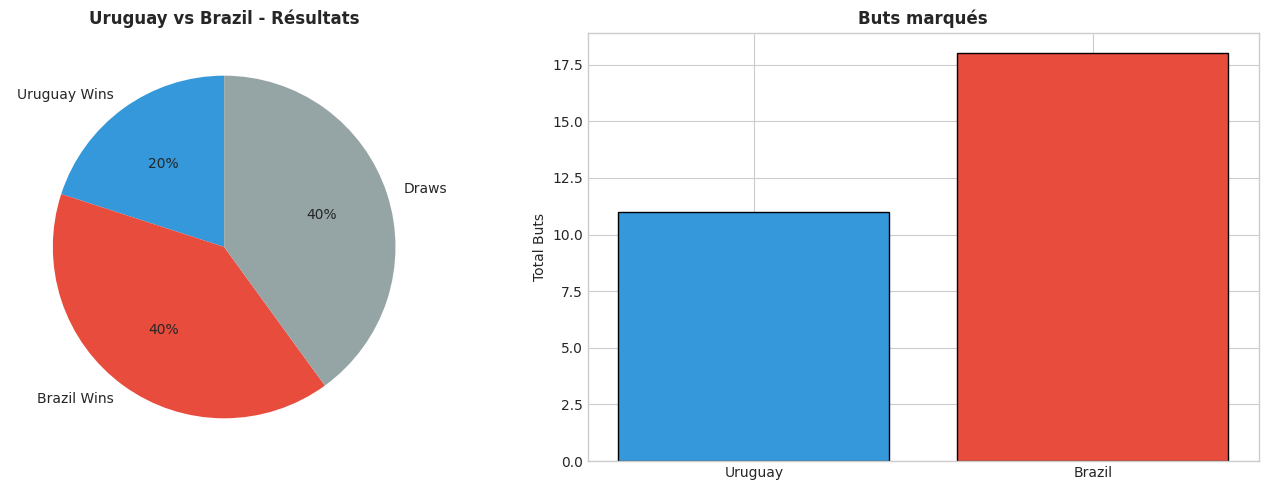

In [12]:
# Visualisation Head-to-Head
if len(df_h2h) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart des résultats
    labels = [f'{team1} Wins', f'{team2} Wins', 'Draws']
    sizes = [df_summary['team1_wins'].iloc[0], df_summary['team2_wins'].iloc[0], df_summary['draws'].iloc[0]]
    colors = ['#3498db', '#e74c3c', '#95a5a6']
    axes[0].pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors, startangle=90)
    axes[0].set_title(f'{team1} vs {team2} - Résultats', fontsize=12, fontweight='bold')
    
    # Bar chart buts
    axes[1].bar([team1, team2], [df_summary['team1_goals'].iloc[0], df_summary['team2_goals'].iloc[0]], 
                color=['#3498db', '#e74c3c'], edgecolor='black')
    axes[1].set_ylabel('Total Buts')
    axes[1].set_title('Buts marqués', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucun match trouvé entre ces deux équipes.")

# 5. Query 2: Performance d'une Équipe par Édition

**Requête paramétrée avec Window Functions** - Analyse l'évolution d'une équipe.

In [13]:
# PARAMÈTRE - Modifiez cette valeur pour changer l'équipe
team = "France"

print(f"Analyse de performance: {team}")

Analyse de performance: France


In [14]:
# Requête avec Window Functions avancées
query_perf = """
SELECT
    edition,
    matches,
    wins,
    draws,
    losses,
    goals_for,
    goals_against,
    goal_diff,
    win_rate,
    -- Rang de cette édition par performance (Window: RANK)
    RANK() OVER (ORDER BY wins DESC, goal_diff DESC) AS rank_by_wins,
    -- Cumul historique des victoires (Window: SUM OVER)
    SUM(wins) OVER (ORDER BY edition ROWS UNBOUNDED PRECEDING) AS cumul_wins,
    -- Cumul historique des matchs
    SUM(matches) OVER (ORDER BY edition ROWS UNBOUNDED PRECEDING) AS cumul_matches,
    -- Moyenne mobile sur 3 éditions (Window: AVG OVER ROWS)
    ROUND(AVG(goals_for::DECIMAL) OVER (
        ORDER BY edition 
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ), 2) AS avg_goals_3_editions,
    -- Différence avec édition précédente (Window: LAG)
    wins - COALESCE(LAG(wins) OVER (ORDER BY edition), 0) AS wins_diff_vs_prev
FROM v_team_by_edition
WHERE nom_standard = :team
ORDER BY edition
"""

df_perf = run_query(query_perf, {'team': team})
print(f"\nPerformance de {team} par édition ({len(df_perf)} participations):")
df_perf


Performance de France par édition (16 participations):


,edition,matches,wins,draws,losses,goals_for,goals_against,goal_diff,win_rate,rank_by_wins,cumul_wins,cumul_matches,avg_goals_3_editions,wins_diff_vs_prev
0,1930,3,1,0,2,4,3,1,33.3,9,1.0,3.0,4.00,1
1,1934,1,0,0,1,2,3,-1,0.0,13,1.0,4.0,3.00,-1
2,1938,2,1,0,1,4,4,0,50.0,10,2.0,6.0,3.33,1
3,1954,2,1,0,1,3,3,0,50.0,10,3.0,8.0,3.00,0
4,1958,6,4,0,2,23,15,8,66.7,5,7.0,14.0,10.00,3
5,1966,3,0,1,2,2,5,-3,0.0,14,7.0,17.0,9.33,-4
6,1978,3,1,0,2,5,5,0,33.3,10,8.0,20.0,10.00,1
7,1982,7,3,1,3,16,12,4,42.9,8,11.0,27.0,7.67,2
8,1986,7,5,1,1,12,6,6,71.4,4,16.0,34.0,11.00,2
9,1998,7,7,0,0,15,2,13,100.0,1,23.0,41.0,14.33,2


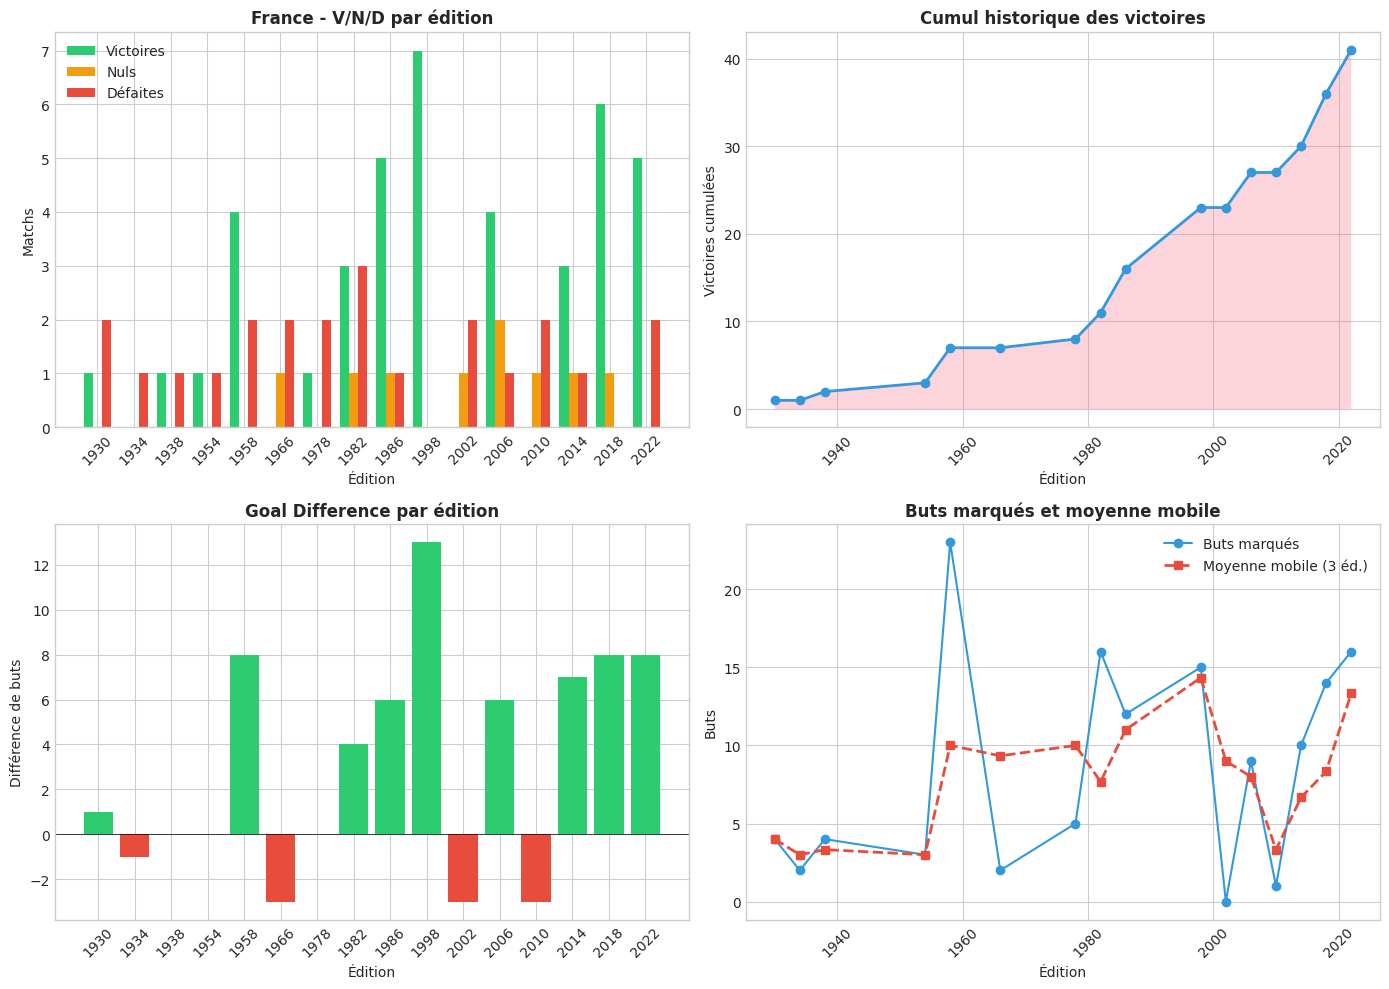

In [15]:
# Visualisation de l'évolution
if len(df_perf) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Évolution V/N/D par édition
    x = range(len(df_perf))
    width = 0.25
    axes[0, 0].bar([i - width for i in x], df_perf['wins'], width, label='Victoires', color='#2ecc71')
    axes[0, 0].bar(x, df_perf['draws'], width, label='Nuls', color='#f39c12')
    axes[0, 0].bar([i + width for i in x], df_perf['losses'], width, label='Défaites', color='#e74c3c')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(df_perf['edition'], rotation=45)
    axes[0, 0].set_xlabel('Édition')
    axes[0, 0].set_ylabel('Matchs')
    axes[0, 0].legend()
    axes[0, 0].set_title(f'{team} - V/N/D par édition', fontweight='bold')
    
    # 2. Cumul victoires
    axes[0, 1].plot(df_perf['edition'], df_perf['cumul_wins'], marker='o', color='#3498db', linewidth=2)
    axes[0, 1].fill_between(df_perf['edition'], df_perf['cumul_wins'], alpha=0.3)
    axes[0, 1].set_xlabel('Édition')
    axes[0, 1].set_ylabel('Victoires cumulées')
    axes[0, 1].set_title('Cumul historique des victoires', fontweight='bold')
    plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Goal difference
    colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in df_perf['goal_diff']]
    axes[1, 0].bar(df_perf['edition'].astype(str), df_perf['goal_diff'], color=colors)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 0].set_xlabel('Édition')
    axes[1, 0].set_ylabel('Différence de buts')
    axes[1, 0].set_title('Goal Difference par édition', fontweight='bold')
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # 4. Moyenne mobile 3 éditions
    axes[1, 1].plot(df_perf['edition'], df_perf['goals_for'], marker='o', label='Buts marqués', color='#3498db')
    axes[1, 1].plot(df_perf['edition'], df_perf['avg_goals_3_editions'], marker='s', linestyle='--', 
                    label='Moyenne mobile (3 éd.)', color='#e74c3c', linewidth=2)
    axes[1, 1].set_xlabel('Édition')
    axes[1, 1].set_ylabel('Buts')
    axes[1, 1].legend()
    axes[1, 1].set_title('Buts marqués et moyenne mobile', fontweight='bold')
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# 6. Query 3: Efficacité Offensive / Défensive

Quelles équipes marquent le plus ? Lesquelles encaissent le moins ?

In [16]:
# Utilise la vue v_team_stats avec HAVING pour filtrer
query_efficiency = """
SELECT
    nom_standard AS team,
    confederation,
    total_matches,
    goals_for,
    goals_against,
    avg_goals_scored,
    avg_goals_conceded,
    -- Ratio offensif/défensif
    ROUND(goals_for::DECIMAL / NULLIF(goals_against, 0), 2) AS goal_ratio,
    clean_sheets,
    -- % clean sheets
    ROUND(100.0 * clean_sheets / NULLIF(total_matches, 0), 1) AS clean_sheet_pct,
    win_rate
FROM v_team_stats
WHERE total_matches >= 10  -- HAVING équivalent en post-agrégation
ORDER BY avg_goals_scored DESC
LIMIT 20
"""

df_efficiency = run_query(query_efficiency)
print("Top 20 équipes par moyenne de buts marqués (min 10 matchs):")
df_efficiency

Top 20 équipes par moyenne de buts marqués (min 10 matchs):


,team,confederation,total_matches,goals_for,goals_against,avg_goals_scored,avg_goals_conceded,goal_ratio,clean_sheets,clean_sheet_pct,win_rate
0,Hungary,UEFA,32,87,57,2.72,1.78,1.53,6,18.8,46.9
1,Brazil,CONMEBOL,114,237,108,2.08,0.95,2.19,48,42.1,70.2
2,Germany,UEFA,112,232,130,2.07,1.16,1.78,41,36.6,64.3
3,Turkey,UEFA,10,20,17,2.00,1.70,1.18,4,40.0,50.0
4,France,UEFA,73,136,85,1.86,1.16,1.60,24,32.9,56.2
5,Netherlands,UEFA,55,96,52,1.75,0.95,1.85,21,38.2,56.4
6,Portugal,UEFA,35,61,41,1.74,1.17,1.49,12,34.3,51.4
7,Argentina,CONMEBOL,88,152,101,1.73,1.15,1.50,31,35.2,60.2
8,Soviet Union,UEFA,31,53,34,1.71,1.10,1.56,13,41.9,48.4
9,Russia,UEFA,14,24,20,1.71,1.43,1.20,2,14.3,35.7


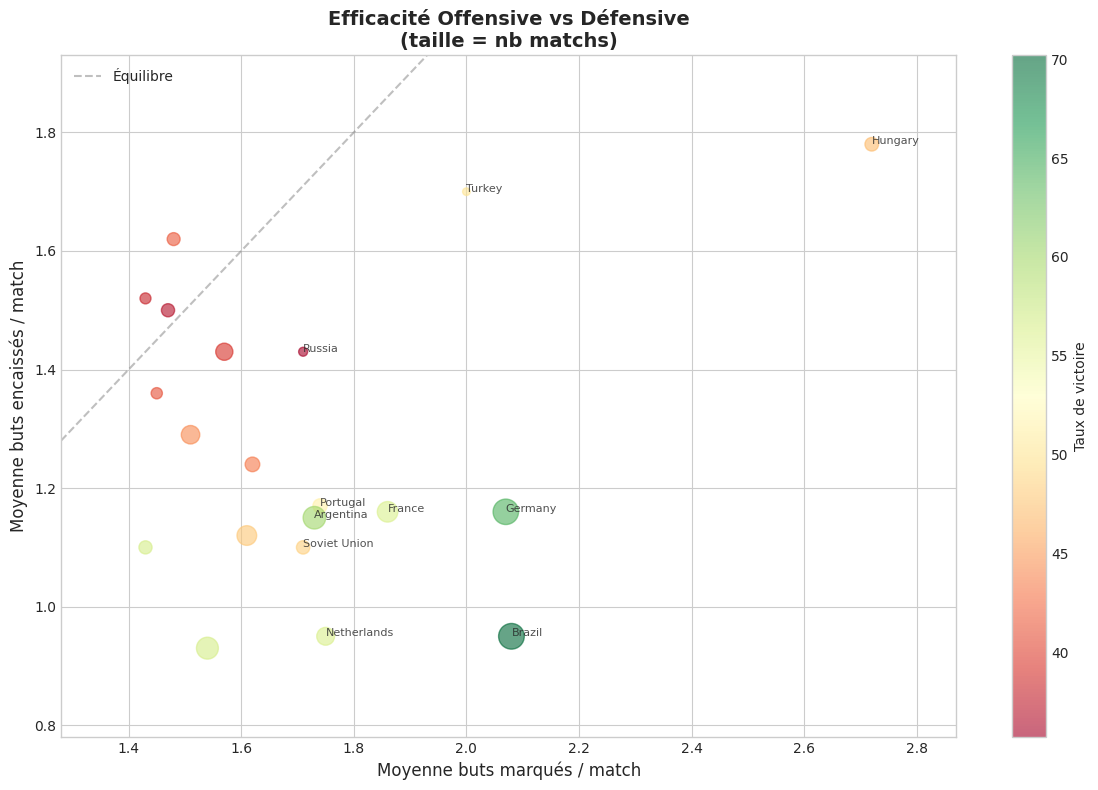

In [17]:
# Scatter plot: Offensive vs Defensive
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    df_efficiency['avg_goals_scored'],
    df_efficiency['avg_goals_conceded'],
    s=df_efficiency['total_matches'] * 3,  # Taille = nombre de matchs
    alpha=0.6,
    c=df_efficiency['win_rate'],
    cmap='RdYlGn'
)

# Annotations
for idx, row in df_efficiency.head(10).iterrows():
    ax.annotate(row['team'], (row['avg_goals_scored'], row['avg_goals_conceded']),
                fontsize=8, alpha=0.8)

ax.set_xlabel('Moyenne buts marqués / match', fontsize=12)
ax.set_ylabel('Moyenne buts encaissés / match', fontsize=12)
ax.set_title('Efficacité Offensive vs Défensive\n(taille = nb matchs)', fontsize=14, fontweight='bold')

# Ajuster les limites des axes pour mieux cadrer les données
x_min, x_max = df_efficiency['avg_goals_scored'].min(), df_efficiency['avg_goals_scored'].max()
y_min, y_max = df_efficiency['avg_goals_conceded'].min(), df_efficiency['avg_goals_conceded'].max()
margin = 0.15
ax.set_xlim(x_min - margin, x_max + margin)
ax.set_ylim(y_min - margin, y_max + margin)

# Ligne de référence (équilibre) - ajustée aux nouvelles limites
ax.plot([x_min - margin, x_max + margin], [x_min - margin, x_max + margin], 
        color='gray', linestyle='--', alpha=0.5, label='Équilibre')

plt.colorbar(scatter, label='Taux de victoire')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 7. Query 4: Impact du Tour (Groupes vs Élimination)

Les matchs à élimination directe sont-ils plus serrés ?

In [18]:
# Comparaison Group Stage vs Knockout avec CASE grouping
query_rounds = """
WITH round_analysis AS (
    SELECT
        -- Catégoriser les tours
        CASE
            WHEN round = 'Group Stage' THEN 'Phase de groupes'
            WHEN round IN ('Round of 16', 'Quarter-finals', 'Semi-finals', 'Third Place', 'Final') 
                THEN 'Phase éliminatoire'
            ELSE 'Autre'
        END AS phase,
        round AS tour_specifique,
        home_result + away_result AS total_goals,
        CASE WHEN result = 'draw' THEN 1 ELSE 0 END AS is_draw,
        extra_time,
        penalties
    FROM matches
    WHERE round != 'Preliminary'
)
SELECT
    phase,
    COUNT(*) AS matchs,
    SUM(total_goals) AS total_buts,
    ROUND(AVG(total_goals), 2) AS moy_buts_match,
    ROUND(100.0 * SUM(is_draw) / COUNT(*), 1) AS pct_nuls,
    SUM(CASE WHEN extra_time THEN 1 ELSE 0 END) AS prolongations,
    SUM(CASE WHEN penalties THEN 1 ELSE 0 END) AS tirs_au_but
FROM round_analysis
WHERE phase != 'Autre'
GROUP BY phase
ORDER BY phase
"""

df_rounds = run_query(query_rounds)
print("Comparaison Phase de groupes vs Phase éliminatoire:")
df_rounds

Comparaison Phase de groupes vs Phase éliminatoire:


,phase,matchs,total_buts,moy_buts_match,pct_nuls,prolongations,tirs_au_but
0,Phase de groupes,676,1808,2.67,24.6,3,0
1,Phase éliminatoire,244,782,3.20,0.0,69,13


In [19]:
# Détail par tour spécifique
query_rounds_detail = """
SELECT
    round AS tour,
    COUNT(*) AS matchs,
    ROUND(AVG(home_result + away_result), 2) AS moy_buts,
    ROUND(100.0 * SUM(CASE WHEN result = 'draw' THEN 1 ELSE 0 END) / COUNT(*), 1) AS pct_nuls
FROM matches
WHERE round IN ('Group Stage', 'Round of 16', 'Quarter-finals', 'Semi-finals', 'Third Place', 'Final')
GROUP BY round
ORDER BY 
    CASE round
        WHEN 'Group Stage' THEN 1
        WHEN 'Round of 16' THEN 2
        WHEN 'Quarter-finals' THEN 3
        WHEN 'Semi-finals' THEN 4
        WHEN 'Third Place' THEN 5
        WHEN 'Final' THEN 6
    END
"""

df_detail = run_query(query_rounds_detail)
print("\nDétail par tour:")
df_detail


Détail par tour:


,tour,matchs,moy_buts,pct_nuls
0,Group Stage,676,2.67,24.6
1,Round of 16,97,3.12,0.0
2,Quarter-finals,70,2.80,0.0
3,Semi-finals,36,3.53,0.0
4,Third Place,20,3.80,0.0
5,Final,21,3.81,0.0


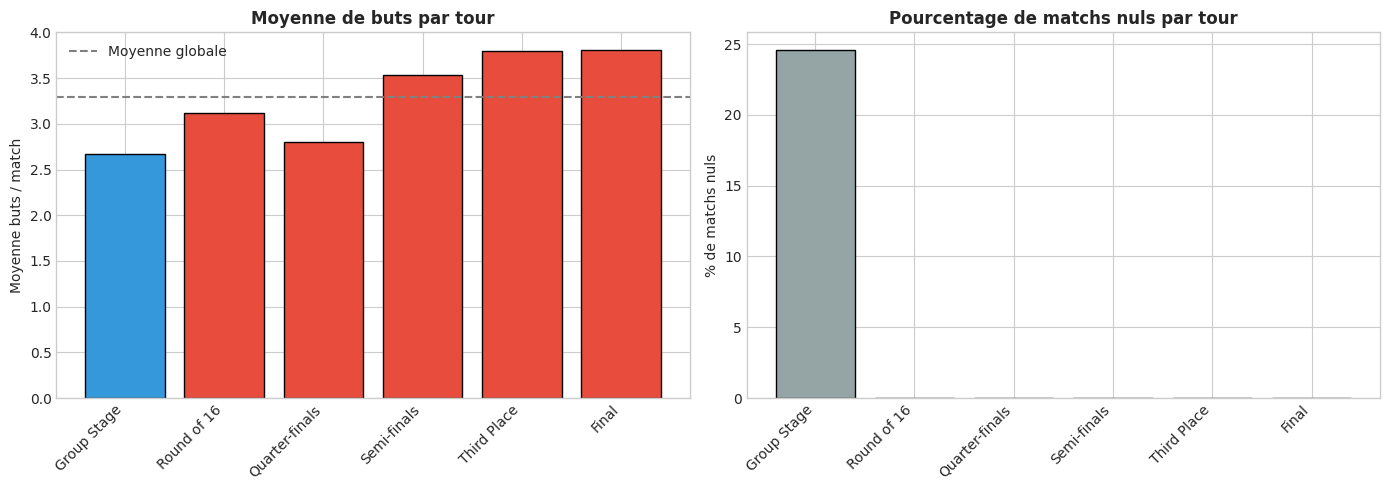

In [20]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart moyenne buts par tour
colors = ['#3498db'] + ['#e74c3c'] * 5
axes[0].bar(df_detail['tour'], df_detail['moy_buts'], color=colors, edgecolor='black')
axes[0].set_ylabel('Moyenne buts / match')
axes[0].set_title('Moyenne de buts par tour', fontweight='bold')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0].axhline(y=df_detail['moy_buts'].mean(), color='gray', linestyle='--', label='Moyenne globale')
axes[0].legend()

# % de nuls par tour
axes[1].bar(df_detail['tour'], df_detail['pct_nuls'], color='#95a5a6', edgecolor='black')
axes[1].set_ylabel('% de matchs nuls')
axes[1].set_title('Pourcentage de matchs nuls par tour', fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 8. Query 5: Villes / Stades les Plus Prolifiques

In [21]:
# Analyse par ville
query_cities = """
SELECT
    city AS ville,
    COUNT(*) AS matchs,
    SUM(home_result + away_result) AS total_buts,
    ROUND(AVG(home_result + away_result), 2) AS moy_buts_match,
    MAX(home_result + away_result) AS max_buts_match,
    STRING_AGG(DISTINCT edition::TEXT, ', ' ORDER BY edition::TEXT) AS editions
FROM matches
WHERE round != 'Preliminary'
  AND city IS NOT NULL
GROUP BY city
HAVING COUNT(*) >= 5
ORDER BY moy_buts_match DESC
LIMIT 20
"""

df_cities = run_query(query_cities)
print("Top 20 villes par moyenne de buts (min 5 matchs):")
df_cities

Top 20 villes par moyenne de buts (min 5 matchs):


,ville,matchs,total_buts,moy_buts_match,max_buts_match,editions
0,Basel,6,44,7.33,11,1954
1,Zürich,5,28,5.60,9,1954
2,Lausanne,5,24,4.80,12,1954
3,Porto Alegre,7,30,4.29,6,"1950, 2014"
4,Liverpool,5,21,4.20,8,1966
5,Arica,7,28,4.00,8,1962
6,Salvador,6,24,4.00,7,2014
7,Córdoba,8,32,4.00,6,1978
8,São Paulo,6,24,4.00,5,1950
9,Bern,5,20,4.00,6,1954


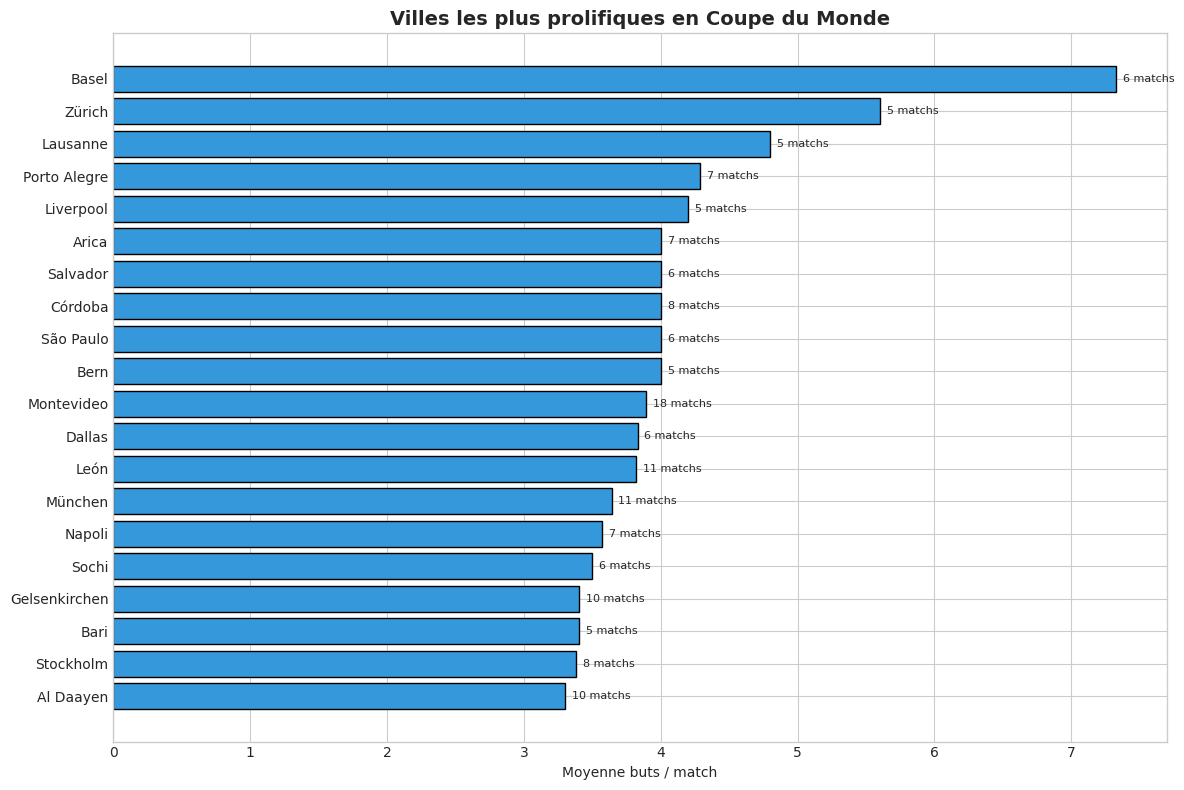

In [22]:
# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal bar chart
y_pos = range(len(df_cities))
ax.barh(y_pos, df_cities['moy_buts_match'], color='#3498db', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_cities['ville'])
ax.invert_yaxis()
ax.set_xlabel('Moyenne buts / match')
ax.set_title('Villes les plus prolifiques en Coupe du Monde', fontsize=14, fontweight='bold')

# Ajouter le nombre de matchs
for i, (matchs, moy) in enumerate(zip(df_cities['matchs'], df_cities['moy_buts_match'])):
    ax.text(moy + 0.05, i, f'{matchs} matchs', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# 9. Query 6: Taux de Victoire Historique

In [23]:
# Top équipes par taux de victoire (utilise la vue)
query_win_rate = """
SELECT
    nom_standard AS equipe,
    confederation,
    total_matches AS matchs,
    wins AS victoires,
    draws AS nuls,
    losses AS defaites,
    win_rate AS taux_victoire,
    -- Points style FIFA (3V + 1N)
    (wins * 3 + draws) AS points,
    ROUND(100.0 * (wins * 3 + draws) / NULLIF(total_matches * 3, 0), 1) AS efficacite_points
FROM v_team_stats
WHERE total_matches >= 10
ORDER BY taux_victoire DESC, matchs DESC
LIMIT 25
"""

df_win_rate = run_query(query_win_rate)
print("Top 25 équipes par taux de victoire (min 10 matchs):")
df_win_rate

Top 25 équipes par taux de victoire (min 10 matchs):


,equipe,confederation,matchs,victoires,nuls,defaites,taux_victoire,points,efficacite_points
0,Brazil,CONMEBOL,114,80,13,21,70.2,253,74.0
1,Germany,UEFA,112,72,16,24,64.3,232,69.0
2,Argentina,CONMEBOL,88,53,10,25,60.2,169,64.0
3,Croatia,UEFA,30,17,4,9,56.7,55,61.1
4,Italy,UEFA,83,47,16,20,56.6,157,63.1
5,Netherlands,UEFA,55,31,10,14,56.4,103,62.4
6,France,UEFA,73,41,9,23,56.2,132,60.3
7,Portugal,UEFA,35,18,5,12,51.4,59,56.2
8,Turkey,UEFA,10,5,1,4,50.0,16,53.3
9,Soviet Union,UEFA,31,15,6,10,48.4,51,54.8


# 10. Query 7: Statistiques de Buts Détaillées

In [24]:
# Statistiques de buts avancées avec NULLIF pour éviter division par zéro
query_goals = """
SELECT
    nom_standard AS equipe,
    total_matches AS matchs,
    goals_for AS buts_pour,
    goals_against AS buts_contre,
    goal_difference AS diff_buts,
    avg_goals_scored AS moy_marques,
    avg_goals_conceded AS moy_encaisses,
    clean_sheets,
    ROUND(100.0 * clean_sheets / NULLIF(total_matches, 0), 1) AS pct_clean_sheets,
    -- Ratio attaque/défense
    ROUND(goals_for::DECIMAL / NULLIF(goals_against, 0), 2) AS ratio_buts
FROM v_team_stats
WHERE total_matches >= 10
ORDER BY diff_buts DESC
LIMIT 20
"""

df_goals = run_query(query_goals)
print("Top 20 équipes par différence de buts (min 10 matchs):")
df_goals

Top 20 équipes par différence de buts (min 10 matchs):


,equipe,matchs,buts_pour,buts_contre,diff_buts,moy_marques,moy_encaisses,clean_sheets,pct_clean_sheets,ratio_buts
0,Brazil,114,237,108,129,2.08,0.95,48,42.1,2.19
1,Germany,112,232,130,102,2.07,1.16,41,36.6,1.78
2,Argentina,88,152,101,51,1.73,1.15,31,35.2,1.50
3,France,73,136,85,51,1.86,1.16,24,32.9,1.60
4,Italy,83,128,77,51,1.54,0.93,30,36.1,1.66
5,Netherlands,55,96,52,44,1.75,0.95,21,38.2,1.85
6,England,74,104,68,36,1.41,0.92,36,48.6,1.53
7,Spain,67,108,75,33,1.61,1.12,22,32.8,1.44
8,Hungary,32,87,57,30,2.72,1.78,6,18.8,1.53
9,Portugal,35,61,41,20,1.74,1.17,12,34.3,1.49


# 11. Query 8: Fréquence des Matchs Nuls

In [25]:
# Équipes qui font le plus de nuls
query_draws = """
WITH draw_analysis AS (
    SELECT
        t.nom_standard,
        COUNT(*) AS total_matchs,
        SUM(CASE WHEN m.result = 'draw' THEN 1 ELSE 0 END) AS nuls,
        SUM(CASE WHEN m.result = 'draw' AND m.home_result = 0 THEN 1 ELSE 0 END) AS nuls_0_0,
        SUM(CASE WHEN m.result = 'draw' AND m.home_result > 0 THEN 1 ELSE 0 END) AS nuls_avec_buts
    FROM teams t
    JOIN matches m ON t.id_team IN (m.home_team_id, m.away_team_id)
    WHERE m.round != 'Preliminary'
    GROUP BY t.nom_standard
    HAVING COUNT(*) >= 10
)
SELECT
    nom_standard AS equipe,
    total_matchs,
    nuls,
    ROUND(100.0 * nuls / total_matchs, 1) AS pct_nuls,
    nuls_0_0,
    nuls_avec_buts
FROM draw_analysis
ORDER BY pct_nuls DESC
LIMIT 20
"""

df_draws = run_query(query_draws)
print("Top 20 équipes par fréquence de matchs nuls (min 10 matchs):")
df_draws

Top 20 équipes par fréquence de matchs nuls (min 10 matchs):


,equipe,total_matchs,nuls,pct_nuls,nuls_0_0,nuls_avec_buts
0,Republic of Ireland,13,6,46.2,2,4
1,Northern Ireland,13,5,38.5,1,4
2,Paraguay,27,9,33.3,3,6
3,Cameroon,26,8,30.8,2,6
4,Scotland,23,7,30.4,2,5
5,Tunisia,18,5,27.8,2,3
6,Bulgaria,26,7,26.9,3,4
7,Morocco,23,6,26.1,3,3
8,Senegal,12,3,25.0,0,3
9,England,74,18,24.3,11,7


# 12. Query 9: Performance en Phase Éliminatoire

In [26]:
# Performance en knockout avec pivoting via CASE
query_knockout = """
WITH knockout_matches AS (
    SELECT
        t.nom_standard,
        m.round,
        CASE
            WHEN (m.home_team_id = t.id_team AND m.result = 'home_team')
                 OR (m.away_team_id = t.id_team AND m.result = 'away_team') THEN 1
            ELSE 0
        END AS win,
        m.extra_time,
        m.penalties
    FROM teams t
    JOIN matches m ON t.id_team IN (m.home_team_id, m.away_team_id)
    WHERE m.round IN ('Round of 16', 'Quarter-finals', 'Semi-finals', 'Third Place', 'Final')
)
SELECT
    nom_standard AS equipe,
    -- Pivot par tour
    SUM(CASE WHEN round = 'Round of 16' THEN 1 ELSE 0 END) AS r16_matchs,
    SUM(CASE WHEN round = 'Round of 16' AND win = 1 THEN 1 ELSE 0 END) AS r16_wins,
    SUM(CASE WHEN round = 'Quarter-finals' THEN 1 ELSE 0 END) AS qf_matchs,
    SUM(CASE WHEN round = 'Quarter-finals' AND win = 1 THEN 1 ELSE 0 END) AS qf_wins,
    SUM(CASE WHEN round = 'Semi-finals' THEN 1 ELSE 0 END) AS sf_matchs,
    SUM(CASE WHEN round = 'Semi-finals' AND win = 1 THEN 1 ELSE 0 END) AS sf_wins,
    SUM(CASE WHEN round = 'Final' THEN 1 ELSE 0 END) AS finales,
    SUM(CASE WHEN round = 'Final' AND win = 1 THEN 1 ELSE 0 END) AS titres,
    -- Total knockout
    COUNT(*) AS total_knockout,
    SUM(win) AS total_wins,
    ROUND(100.0 * SUM(win) / NULLIF(COUNT(*), 0), 1) AS knockout_win_rate,
    SUM(CASE WHEN penalties THEN 1 ELSE 0 END) AS tirs_au_but
FROM knockout_matches
GROUP BY nom_standard
HAVING COUNT(*) >= 5
ORDER BY titres DESC, knockout_win_rate DESC
LIMIT 20
"""

df_knockout = run_query(query_knockout)
print("Top 20 équipes en phase éliminatoire (min 5 matchs):")
df_knockout

Top 20 équipes en phase éliminatoire (min 5 matchs):


,equipe,r16_matchs,r16_wins,qf_matchs,qf_wins,sf_matchs,sf_wins,finales,titres,total_knockout,total_wins,knockout_win_rate,tirs_au_but
0,Brazil,12,10,15,9,8,6,6,5,45,32,71.1,2
1,Italy,8,6,8,7,7,6,6,4,31,24,77.4,0
2,Germany,11,9,14,11,12,7,8,4,50,35,70.0,0
3,Argentina,10,7,8,4,4,4,6,3,28,18,64.3,3
4,France,8,7,8,6,6,3,4,2,29,20,69.0,1
5,Spain,9,5,6,1,1,1,1,1,17,8,47.1,2
6,England,8,6,10,3,3,1,1,1,24,11,45.8,1
7,Uruguay,5,2,5,3,4,1,1,1,18,7,38.9,0
8,Croatia,3,3,3,3,2,1,1,0,11,9,81.8,4
9,Czechoslovakia,3,3,5,2,2,2,2,0,12,7,58.3,0


# 13. Query 10: Expérience en Coupe du Monde

In [27]:
# Expérience avec DENSE_RANK
query_experience = """
WITH experience AS (
    SELECT
        nom_standard,
        confederation,
        editions,
        total_matches,
        wins,
        win_rate,
        -- Score d'expérience pondéré
        (editions * 10) + total_matches + (wins * 2) AS experience_score
    FROM v_team_stats
)
SELECT
    nom_standard AS equipe,
    confederation,
    editions AS participations,
    total_matches AS matchs,
    wins AS victoires,
    win_rate AS taux_victoire,
    experience_score,
    -- Rang par confédération
    DENSE_RANK() OVER (PARTITION BY confederation ORDER BY experience_score DESC) AS rang_confederation,
    -- Rang global
    DENSE_RANK() OVER (ORDER BY experience_score DESC) AS rang_global
FROM experience
WHERE editions >= 1
ORDER BY experience_score DESC
LIMIT 30
"""

df_experience = run_query(query_experience)
print("Top 30 équipes par expérience en Coupe du Monde:")
df_experience

Top 30 équipes par expérience en Coupe du Monde:


,equipe,confederation,participations,matchs,victoires,taux_victoire,experience_score,rang_confederation,rang_global
0,Brazil,CONMEBOL,22,114,80,70.2,494,1,1
1,Germany,UEFA,20,112,72,64.3,456,1,2
2,Argentina,CONMEBOL,18,88,53,60.2,374,2,3
3,Italy,UEFA,18,83,47,56.6,357,2,4
4,France,UEFA,16,73,41,56.2,315,3,5
5,England,UEFA,16,74,33,44.6,300,4,6
6,Spain,UEFA,16,67,32,47.8,291,5,7
7,Mexico,CONCACAF,17,60,17,28.3,264,1,8
8,Uruguay,CONMEBOL,14,59,26,44.1,251,3,9
9,Belgium,UEFA,14,51,22,43.1,235,6,10


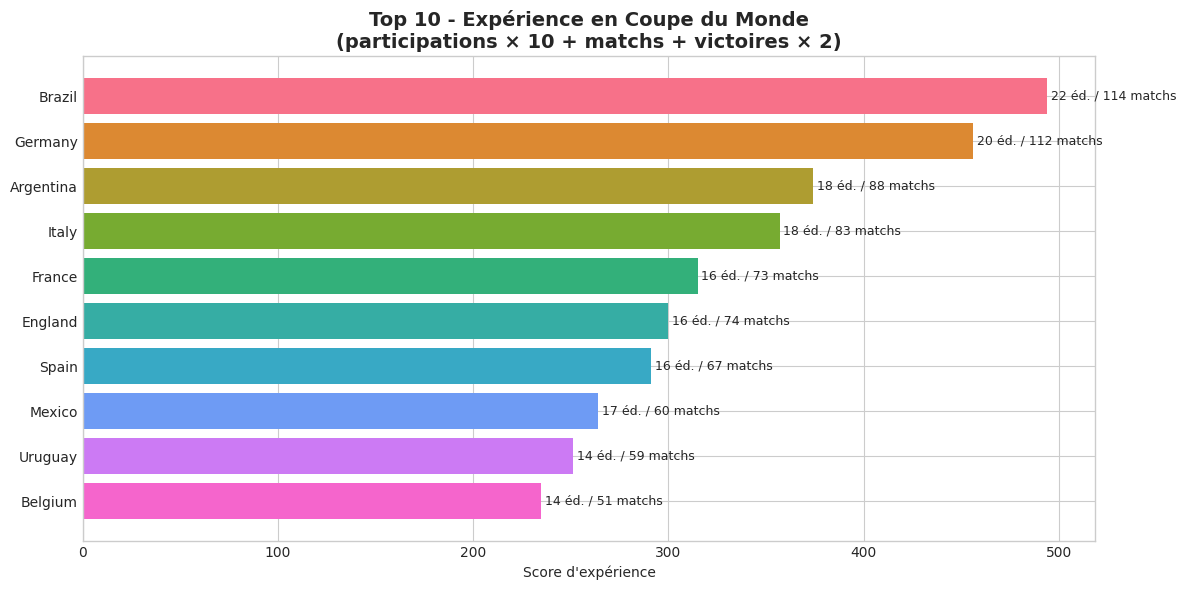

In [28]:
# Visualisation finale: Top 10 par expérience
fig, ax = plt.subplots(figsize=(12, 6))

top10 = df_experience.head(10)
colors = sns.color_palette('husl', n_colors=10)

bars = ax.barh(range(len(top10)), top10['experience_score'], color=colors)
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['equipe'])
ax.invert_yaxis()
ax.set_xlabel('Score d\'expérience')
ax.set_title('Top 10 - Expérience en Coupe du Monde\n(participations × 10 + matchs + victoires × 2)', 
             fontsize=14, fontweight='bold')

# Annotations
for i, (score, parts, matchs) in enumerate(zip(top10['experience_score'], top10['participations'], top10['matchs'])):
    ax.text(score + 2, i, f'{parts} éd. / {matchs} matchs', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 14. Récapitulatif des Techniques SQL Démontrées

| Technique | Section | Exemple |
|-----------|---------|--------|
| **Partitionnement** | 2 | `EXPLAIN ANALYZE`, Partition Pruning |
| **Vues** | 3 | `v_team_stats`, `v_team_by_edition`, `v_head_to_head` |
| **CTE (WITH)** | 4, 8, 10 | `WITH confrontations AS (...)` |
| **Paramètres** | 4, 5 | `:team1`, `:team2`, `:team` |
| **CASE WHEN** | 4, 7, 9 | Conditional aggregation |
| **Window Functions** | 5, 10 | `RANK()`, `SUM() OVER`, `LAG()`, `DENSE_RANK()` |
| **Moyenne mobile** | 5 | `AVG() OVER (ROWS BETWEEN 2 PRECEDING...)` |
| **HAVING** | 6, 8 | `HAVING COUNT(*) >= 10` |
| **NULLIF** | 6, 7 | `NULLIF(total, 0)` évite div/0 |
| **STRING_AGG** | 5, 8 | Concaténation de listes |
| **LEAST/GREATEST** | Vue h2h | Normalisation des paires |
| **Index partiels** | Setup | `WHERE date IS NOT NULL` |